In [16]:
from PIL import Image, ImageTk
import tkinter
from numpy import array, asarray, zeros, ones, roll, uint8, hstack
import customtkinter
from XRDXRFutils import DataXRF

In [28]:
class MenuFrame(customtkinter.CTkFrame):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.grid_rowconfigure(0, weight = 1)
        
        self.read_button = customtkinter.CTkButton(master = self, text = "Read", command=self.read_callback)
        self.read_button.grid(row = 0, column = 0, padx = 5, pady = 5, sticky = "ew")
        
        self.save_button = customtkinter.CTkButton(master = self, text = "Save", command=self.save_callback)
        self.save_button.grid(row = 0, column = 1, padx = 5, pady = 5, sticky = "ew")
        
        self.inpath = None
        self.outpath = None
        
    def read_callback(self):
        self.inpath = customtkinter.filedialog.askdirectory()
        self.master.read(self.inpath)
    
    def save_callback(self):
        self.outpath = customtkinter.filedialog.asksaveasfilename(filetypes = [("HDF5", "*.h5")])
        self.master.save(self.outpath)

class App(customtkinter.CTk):
    def __init__(self):
        super().__init__()
        
        customtkinter.set_appearance_mode('dark')       
        customtkinter.set_default_color_theme('dark-blue')

        
        self.title("My app")
        
        self.data = None
        self.shiftmag = 0
        
        self.norm = lambda x: (x/x.max()*255).astype(uint8)
        
        self.img = zeros((200,300,3))
        #self.img = asarray(Image.open('/home/rosario/Immagini/img_profilo_shift.png'), uint8).sum(2)
        
        shape = self.img.shape
        self.imsize = (shape[1], shape[0])
#         if shape[0] < shape[1]:
#             self.landscape = True
#             self.ratio = shape[0]/shape[1]
#         else:
#             self.landscape = False
#             self.ratio = shape[1]/shape[0]
        self.ratio = shape[1]/shape[0]
            
        #self.ratio = min(shape)/max(shape)
        self.geometry(f"800x500")
        
        self.grid_rowconfigure((0,1), weight = 1)
        self.grid_columnconfigure((0,1), weight =1)

        #self.canvas = customtkinter.CTkCanvas(master = self, width = shape[0], height = shape[1])
        self.menu_bar = MenuFrame(master = self)
        self.menu_bar.grid(row = 0, column = 0, columnspan = 2, padx = 20, pady = (5,0), sticky = "ew")
        
        self.canvas = customtkinter.CTkFrame(master = self)
        self.canvas.grid(row = 1, column = 0, columnspan = 2, padx = 20, pady = 20, sticky = "nsew")
        self.canvas.grid_rowconfigure(0, weight = 1)
        self.canvas.grid_columnconfigure(0, weight = 1)
        
        self.canvas.update_idletasks()
        self.wshape = (self.canvas.winfo_width()-20, self.canvas.winfo_height()-20)
        
        
#ImageTk.PhotoImage(image=Image.fromarray(norm(img.sum(2))))
        pil_img = Image.fromarray(self.norm(self.img))
        self.image = ImageTk.PhotoImage(master = self,image=pil_img)
        self.label = customtkinter.CTkLabel(master = self.canvas, image=self.image, text = None)
        self.label.grid(row = 0, column = 0, padx = 10, pady = 10, columnspan = 2, sticky = "nswe")
        #self.container = self.canvas.create_image(0,0, anchor = "nw",image = self.image)
    
        self.roll_button = customtkinter.CTkButton(master = self, text = "roll", command = self.roll_btn_callback)
        self.roll_button.grid(row = 2, column = 0, padx = 10, pady = (0,20))
        
        self.unroll_button = customtkinter.CTkButton(master = self, text = "unroll", command = self.unroll_btn_callback)
        self.unroll_button.grid(row = 2, column = 1, padx = 10, pady = (0,20))
        
        #self.bind("<ButtonRelease>", self.resize)
        self.bind("<Configure>", self.resize)
        print(self.imsize, self.wshape)
        self.resize()
        #print(self.landscape)
    
    def read(self, inpath):
        self.inpath = inpath
        self.data = DataXRF().read_from_map(self.inpath)
        self.img = self.data.data.sum(2)
        self.update_image()
        
    
    def save(self, outpath):
        self.outpath = outpath
        if self.data:
            self.data.data = shift(self.data.data.copy(), self.shiftmag)
            self.data.save_h5(self.outpath)
        
        
    def roll_btn_callback(self):
        self.update_idletasks()
        self.img[::2] = roll(self.img[::2], 1, axis = 1)
        self.img[1::2] = roll(self.img[1::2], -1, axis = 1)
        self.shiftmag += 1
        self.update_image()
#         pil_img = Image.fromarray(self.norm(self.img)).resize((int(self.wshape[1]*self.ratio), self.wshape[1]))
#         self.image = ImageTk.PhotoImage(master = self, image = pil_img)
#         #self.canvas.create_image(0,0, anchor = "nw",image = self.image)
#         #self.canvas.itemconfig(self.container, image = self.image)
#         self.label.configure(image = self.image)
    
    def unroll_btn_callback(self):
        self.update_idletasks()
        self.img[::2] = roll(self.img[::2], -1, axis = 1)
        self.img[1::2] = roll(self.img[1::2], 1, axis = 1)
        self.shiftmag -= 1
        self.update_image()
#         pil_img = Image.fromarray(self.norm(self.img)).resize((int(self.wshape[1]*self.ratio), self.wshape[1]))
#         self.image = ImageTk.PhotoImage(master = self, image = pil_img)
#         self.label.configure(image = self.image)
    
    def update_image(self):
        pil_img = Image.fromarray(self.norm(self.img)).resize(self.imsize)
        self.image = ImageTk.PhotoImage(master = self, image = pil_img)
        self.label.configure(image = self.image)
    
    def resize(self,event = None):
        self.canvas.update_idletasks()
        #print("released")
        if self.canvas.winfo_width() != self.wshape[0]+20 or self.canvas.winfo_height() != self.wshape[1]+20:
            self.wshape = (self.canvas.winfo_width()-20, self.canvas.winfo_height()-20)
#             if self.landscape:
#                 self.imsize = (self.wshape[0],int(self.wshape[0]*self.ratio))
#             else:
#                 self.imsize = (int(self.wshape[1]*self.ratio),self.wshape[1])
            if self.wshape[1]*self.ratio >= self.wshape[0]:
                self.imsize = (self.wshape[0], int(self.wshape[0]/self.ratio))
            else:
                self.imsize = (int(self.wshape[1]*self.ratio), self.wshape[1])
                
            self.update_image()

def shift(x,n,method = 'both'):
    
    def pad(x,n):
        x = hstack((zeros((x.shape[0],abs(n),x.shape[2])), x, zeros((x.shape[0],abs(n),x.shape[2]))))
    
    pad(x,n)
    if method == 'both':
        x[::2] = roll(x[::2], n, axis = 1)
        x[1::2] = roll(x[1::2], -n, axis = 1)
    elif method == 'even':
        x[::2] = roll(x[::2], n, axis = 1)
    elif method == 'odd':
        x[1::2] = roll(x[1::2], -n, axis = 1)
    else:
        return None
    return x

In [29]:
myapp = App()
myapp.mainloop()

/tmp/ipykernel_2612682/1985785254.py:37: RuntimeWarning: invalid value encountered in divide
  self.norm = lambda x: (x/x.max()*255).astype(uint8)


(300, 200) (740, 289)


In [36]:
myapp.label.winfo_width()

322

In [37]:
myapp.mainloop()

In [29]:
max((1,3))

3

In [60]:
a = 1
b = 3
ratio = a/b

In [61]:
ratio

0.3333333333333333

In [62]:
4*ratio

1.3333333333333333

In [63]:
2*ratio

0.6666666666666666

In [5]:
def shift(img, n):
    img[::2] = roll(img[::2], n, axis = 1)
    img[1::2] = roll(img[1::2], -n, axis = 1)
    return img

In [56]:
pil_img = Image.open('/home/rosario/Immagini/img_profilo.jpg')
ratio = min(pil_img.size)/max(pil_img.size)
print(ratio)
#pil_img = pil_img.resize((int(250*ratio), 250))
print(pil_img.size)
img = asarray(pil_img, uint8)

0.7974947807933194
(382, 479)


In [57]:
from matplotlib.pyplot import imshow

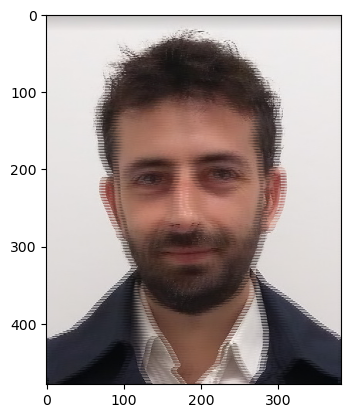

In [59]:
shimg = shift(img.copy(), 4)
imshow(shimg)

In [60]:
out = Image.fromarray(shimg).save('/home/rosario/Immagini/img_profilo_shift.png')

In [51]:
200/ratio

250.78534031413614